In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Get Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # mu and logvar
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = x.view(-1, 28 * 28)  # Flatten MNIST images
        hidden = self.encoder(x)
        mu, logvar = torch.chunk(hidden, 2, dim=1)
        return mu, logvar

    def decode(self, z):
        reconstructed = self.decoder(z)
        return reconstructed

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar

In [4]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=128, shuffle=True
)

In [5]:
# Initialize VAE model
input_dim = 28 * 28
hidden_dim = 256
latent_dim = 20
vae = VAE(input_dim, hidden_dim, latent_dim).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
criterion = nn.BCELoss(reduction='sum')

In [6]:
# Inside your training loop
def train_vae(model, optimizer, criterion, train_loader, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data.to(device))
            loss = criterion(recon_batch, data.view(-1, 784).to(device))
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss += kl_divergence
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader.dataset)}")

# Train the VAE with gradient clipping
train_vae(vae, optimizer, criterion, train_loader)  # Set clip_value to your desired threshold

Epoch 1/20, Loss: -21427.786226497396
Epoch 2/20, Loss: -30429.10515
Epoch 3/20, Loss: -37724.997520833334
Epoch 4/20, Loss: -43602.41
Epoch 5/20, Loss: -48435.29138333334
Epoch 6/20, Loss: -51118.64038333333
Epoch 7/20, Loss: -52791.11435833333
Epoch 8/20, Loss: -53956.621908333334
Epoch 9/20, Loss: -54789.19989166666
Epoch 10/20, Loss: -55572.977066666666
Epoch 11/20, Loss: -56199.50549166666
Epoch 12/20, Loss: -56661.234875
Epoch 13/20, Loss: -57049.69326666667
Epoch 14/20, Loss: -57202.02180833333
Epoch 15/20, Loss: -57385.66371666667
Epoch 16/20, Loss: -57590.6441
Epoch 17/20, Loss: -57824.063916666666
Epoch 18/20, Loss: -57991.575058333336
Epoch 19/20, Loss: -58148.50050833333
Epoch 20/20, Loss: -58275.394925


In [24]:
# Latent space attack function
def latent_space_attack(vae, xo, xt, lambda_val=0.1, num_iterations=500):
    vae.eval()
    xo = xo.view(-1, 28 * 28)
    xt = xt.view(-1, 28 * 28)
    
    xo_perturbed = xo.clone().requires_grad_()
    optimizer = torch.optim.Adam([xo_perturbed], lr=1e-3)
    
    for i in range(num_iterations):
        optimizer.zero_grad()
        
        reconstructed_xo, mu_xo, logvar_xo = vae(xo_perturbed)
        reconstructed_xt, mu_xt, logvar_xt = vae(xt)
        
        kl_divergence = torch.sum(0.5 * (logvar_xo.exp() - logvar_xo - 1 + logvar_xt))
        l2_norm = torch.sum((mu_xo - mu_xt) ** 2)  # Using mean difference for closeness
        
        loss = kl_divergence + lambda_val * l2_norm
        
        loss.backward()
        optimizer.step()
        
    return xo_perturbed.detach()

In [25]:
# Example usage of the attack
target_idx = 0  # Choose a target image index
input_idx = 1  # Choose an input image index

xt, _ = train_loader.dataset[target_idx]
xo, _ = train_loader.dataset[input_idx]

perturbed_xo = latent_space_attack(vae.to('cpu'), xo, xt)

In [26]:
# Visualize original, target, and perturbed images
def show_images(original, target, perturbed):
    fig, axs = plt.subplots(1, 3)
    
    axs[0].imshow(original.reshape(28, 28), cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')
    
    axs[1].imshow(target.reshape(28, 28), cmap='gray')
    axs[1].set_title('Target')
    axs[1].axis('off')
    
    axs[2].imshow(perturbed.reshape(28, 28), cmap='gray')
    axs[2].set_title('Perturbed')
    axs[2].axis('off')
    
    plt.show()

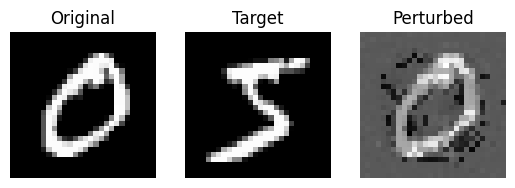

In [27]:
show_images(xo.squeeze().detach().numpy(), xt.squeeze().detach().numpy(), perturbed_xo.squeeze())

In [28]:
# Example usage of the attack
target_idx = 0  # Choose a target image index
input_idx = 1  # Choose an input image index

xt, _ = train_loader.dataset[target_idx]
xo, _ = train_loader.dataset[input_idx]

perturbed_xo = latent_space_attack(vae, xo, xt)

# Reconstruction using the perturbed image
reconstructed_perturbed_xo, _, _ = vae(perturbed_xo)

In [36]:
# Visualize original, target, perturbed, and reconstructed images
def show_images(original, target, perturbed, reconstructed_original, reconstructed_perturbed):
    fig, axs = plt.subplots(1, 5, figsize=(20, 6))
    
    axs[0].imshow(original.reshape(28, 28), cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')
    
    axs[1].imshow(target.reshape(28, 28), cmap='gray')
    axs[1].set_title('Target')
    axs[1].axis('off')
    
    axs[2].imshow(perturbed.reshape(28, 28), cmap='gray')
    axs[2].set_title('Perturbed')
    axs[2].axis('off')
    
    axs[3].imshow(reconstructed_original.reshape(28, 28), cmap='gray')
    axs[3].set_title('Reconst from Orig')
    axs[3].axis('off')
    
    axs[4].imshow(reconstructed_perturbed.reshape(28, 28), cmap='gray')
    axs[4].set_title('Reconst from Perturb')
    axs[4].axis('off')
    
    plt.tight_layout()
    plt.show()
plt.rcParams.update({'font.size': 22})


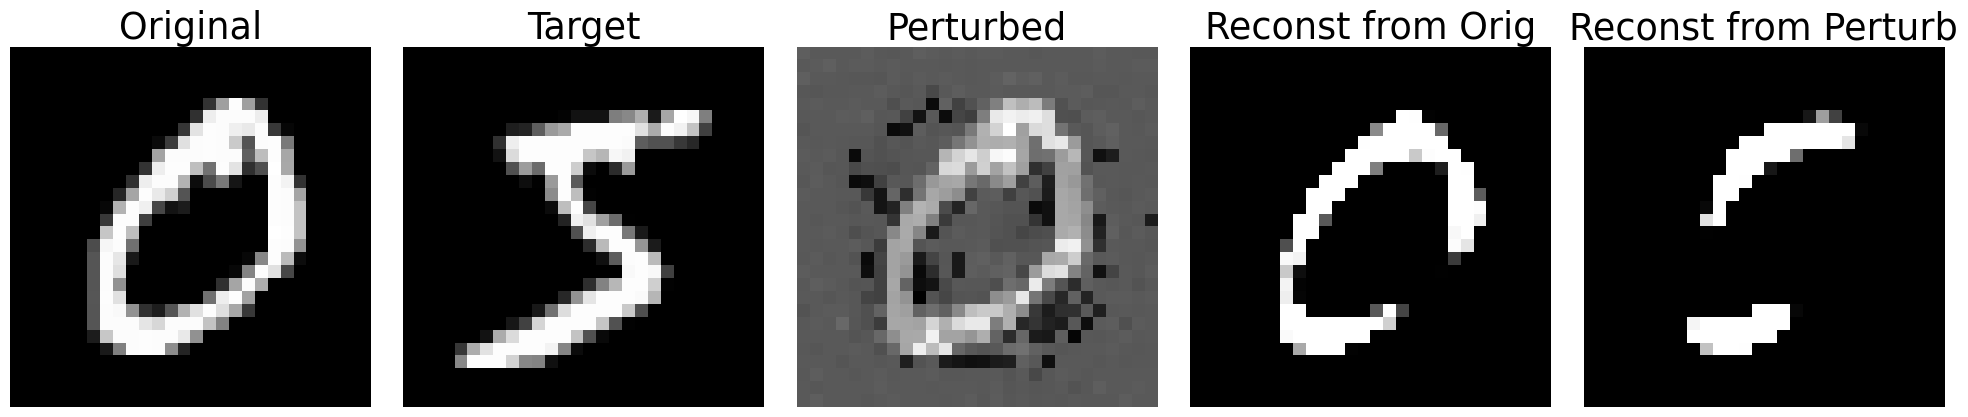

In [37]:
reconstructed_xo, _, _ = vae(xo.unsqueeze(0))
show_images(
    xo.squeeze().detach().cpu().numpy(),
    xt.squeeze().detach().cpu().numpy(),
    perturbed_xo.squeeze().detach().cpu().numpy(),
    reconstructed_xo.squeeze().detach().cpu().numpy(),
    reconstructed_perturbed_xo.squeeze().detach().cpu().numpy()
)

In [23]:
# Function to compute reconstruction distances for each input in the dataset
def compute_reconstruction_distances(vae_model, inputs):
    distances = []
    for x in inputs:
        with torch.no_grad():
            # Encode the input x to get mean and logvar
            mu, logvar = vae_model.encode(x)
            # Reparameterize to get the latent representation z
            z = vae_model.reparameterize(mu, logvar)
            # Reconstruct the input from the latent space
            reconstructed = vae_model.decode(z)
            # Resize the reconstructed tensor to match the input size
            reconstructed = reconstructed.view(-1, 28 * 28)
            # Compute the reconstruction distance and store it
            dist = torch.dist(x.view(-1, 28 * 28), reconstructed, p=2)  # Using L2 norm
            distances.append(dist.item())
    return distances

# Function to measure r-robustness based on the computed distances
def measure_r_robustness_vae(vae_model, inputs, r):
    distances = compute_reconstruction_distances(vae_model, inputs)
    within_r = np.sum(np.array(distances) <= r)
    outside_r = len(inputs) - within_r
    within_r_prob = within_r / len(inputs)
    outside_r_prob = outside_r / len(inputs)
    return within_r_prob, outside_r_prob

# Example usage
data_only = [data for data, _ in train_loader.dataset]
r = 26  # Define your radius r
within_r_prob, outside_r_prob = measure_r_robustness_vae(vae, data_only, r)
print(f"Probability within r: {within_r_prob}")
print(f"Probability outside r: {outside_r_prob}")


Probability within r: 0.5340166666666667
Probability outside r: 0.46598333333333336


In [ ]:
def find_critical_r(vae_model, data, r_range):
    for r in r_range:
        within_r_prob, outside_r_prob = measure_r_robustness_vae(vae_model, data, r)
        if within_r_prob > outside_r_prob:
            return r
    return None  # If not found within the given range

# Define a range of r values to search through
r_values = np.linspace(start=26, stop=27, num=10)

# Find the critical r
critical_r = find_critical_r(vae, data_only, r_values)
print(f"Critical r: {critical_r}")